<div>
<img src="figures\svtLogo.png"/>
</div>  

<center><h1>Mathematical Optimization for Engineers</h1></center>
<center><h2>Lab 10 - Deterministic Global Optmization</h2></center>

In this exercise, we'll look at deterministic global optimization of boxconstrained two-dimensional non-convex problems. We will implement the branch-and-bound method and use the $\alpha$BB method to construct convex relaxations of non-convex objective functions.
<br>
<br>
$$\begin{aligned}
        \min_{\mathbf x\in X} \quad f(\mathbf x) \\
        %\mbox{s.t. } \quad g & \; \leq \; 15 \\
\end{aligned}$$
<br>
<br>
<u>Task</u>: Go through the code and fill in the missing bits to complete the implementation. Missing bits are marked with the comment <i># add your code here</i>

In [1]:
import numpy as np

# we will use a local solver from scipy for upper-bounding problem
from scipy import optimize as sp

# to construct relaxations for lower-bounding problem
from math import inf, sin, cos, sqrt

# for branching
import copy

# for plotting
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

### Objective functions, to experiment on: 
Return $f(\mathbf x)$ for input $\mathbf x$

In [2]:
def sixhump(x): #scipy-lectures.org/intro/scipy/auto_examples/plot_2d_minimization.html
    return ((4 - 2.1*x[0]**2 + x[0]**4 / 3.) * x[0]**2 + x[0] * x[1] + (-4 + 4*x[1]**2) * x[1] **2)

In [3]:
def adjiman (X):
    x, y = X[0], X[1]
    return (np.cos(x) * np.sin(y)) - (x / (y**2.0 + 1.0))

In [4]:
def schwefel(x):
    n = 2
    s = 0
    for i in range(0,n):
        s = s - 1 * x[i] * sin(sqrt(abs(x[i])))
    y = 418.9829 * n + s
    return y

In [5]:
def griewank(x):
    x1 = x[0]
    x2 = x[1]
    sum = 0
    prod = 1

    sum = sum + x1 ** 2 / 4000
    prod = prod * np.cos(x1 / sqrt(1))

    sum = sum + x2 ** 2 / 4000
    prod = prod * np.cos(x2 / sqrt(2))

    y = sum - prod + 1
    return y

In [6]:
def camel3(xx):

    x1 = xx[0]
    x2 = xx[1]

    term1 = 2*x1**2
    term2 = -1.05*x1**4
    term3 = x1**6 / 6
    term4 = x1*x2
    term5 = x2**2
    return  term1 + term2 + term3 + term4 + term5

### Compute convex relaxations using $\alpha$BB method
Returns cv($f(\mathbf x)$), for inputs $\mathbf x,\; f(\mathbf x),\; \alpha,\; \mathbf x^L\;$and $\mathbf x^U$

In [7]:
def relaxedFunction(x, function, alpha, lb, ub): 
    # using alphaBB method
    
    lb = np.array(lb)
    ub = np.array(ub)
    y = function(x) - alpha* np.dot((x-lb),(ub - x))

    return y

### Compute upper bound for current node
Writes "ubd" attribute of newly created nodes. Returns updated list of nodes.

In [8]:
def computeUpperBounds(nodes, objective):
    for iNode in nodes:
        if iNode["ubd"] == inf: 
            x0 = (np.array(iNode["lb"]) + np.array(iNode["ub"]))/2
            bnds = []
            for i in range(0, len(lb)):
                bnds.append((lb[i], ub[i]))
    
            solUBD = sp.minimize(objective, x0, bounds = bnds, method='L-BFGS-B', jac=None)
            iNode["ubd"] = solUBD.fun
            
    return nodes

### Compute lower bound for current node
Writes "lbd" attribute of newly created nodes. Returns updated list of nodes.

In [9]:
def computeLowerBounds(nodes, objective, alpha):
    for iNode in nodes:
        if iNode["ubd"] == inf: 
            x0 = (np.array(iNode["lb"]) + np.array(iNode["ub"]))/2
            bnds = []
            for i in range(0, len(lb)):
                bnds.append((iNode["lb"][i], iNode["ub"][i]))
            
    
            solLBD = sp.minimize(relaxedFunction, x0, args=(objective, alpha, iNode["lb"], iNode["ub"]), bounds = bnds, method='L-BFGS-B', jac=None)
            iNode["lbd"] = solLBD.fun
            
    return nodes

### Branch 

In [10]:
def branching(nodes, globalLBD): 
    epsilonF = 0.001
    
    chosenNode = nodes[0]
    # choose node with lowest LBD 
    for iNode in nodes: 
        if iNode["lbd"] <= globalLBD + epsilonF:
            chosenNode = iNode
            break
    
    # branch on variable with largest variable bounds
    delta = np.array(chosenNode["ub"]) - np.array(iNode["lb"])
    indVariable = np.argmax(delta)
    print("max delta: ", max(delta))
    
    # simply branch in the middle
    iNodeLeft = copy.deepcopy(chosenNode)
    iNodeLeft["ub"][indVariable] = iNodeLeft["lb"][indVariable] + \
                                   (iNodeLeft["ub"][indVariable] - iNodeLeft["lb"][indVariable])/2
    iNodeLeft["lbd"] = - inf
    iNodeLeft["ubd"] = + inf

    
    iNodeRight = copy.deepcopy(chosenNode)
    iNodeRight["lb"][indVariable] = iNodeLeft["ub"][indVariable]
    iNodeRight["lbd"] = - inf
    iNodeRight["ubd"] = + inf

    
    # bookkeeping
    nodes.remove(chosenNode)
    nodes.append(iNodeLeft)
    nodes.append(iNodeRight)
       
    
    return nodes

### Fathoming
Returns true or false for given node and global upper bound.

In [11]:
def fathom(iNode, globalUBD):
    # fathom if true
    if iNode["lbd"] > globalUBD:
        return True
    else:
        return False

### Main function
Returns global minimum for given objective function, box constraints: $\mathbf x^L\;$and $\mathbf x^U$, and $\alpha$.

In [12]:
def branchAndBoundAlgorithm(objective, lb, ub, alpha):
 
    foundGlobalSolution = False
    epsilonF = 0.001 # absolute tolerance
    UBD = inf
    LBD = -inf
    nodes = []

    # initial point
    x0 = (np.array(lb) + np.array(ub))/2
    
    bnds = []
    for i in range(0, len(lb)):
        bnds.append((lb[i], ub[i]))
    
    # compute upper bound
    solUBD = sp.minimize(objective, x0, bounds = bnds, method='L-BFGS-B', jac=None)
    # compute lower bound 
    solLBD = sp.minimize(relaxedFunction, x0, bounds = bnds, args=(objective, alpha, lb, ub), method='L-BFGS-B', jac=None)
    
    # current global upper and lower bounds
    UBD = solUBD.fun
    LBD = solLBD.fun
    
    # create first node
    node = {
        "ubd": solUBD.fun,
        "lbd": solLBD.fun,
        "lb": lb,
        "ub": ub
    }
    nodes.append(node)
    
    iteration = 0
    while not foundGlobalSolution: 
        # convergence check 
        if ( UBD - LBD ) < epsilonF:
            foundGlobalSolution = True
            print("diff ", UBD - LBD)
            print("upper bound: ", UBD, "lower bound: ", LBD)
            break
        iteration = iteration + 1
        print("iter: ", iteration)
        print("epsilionF: ", UBD-LBD, "UBD: ", UBD, "LBD: ", LBD)       
        
        # branching (on largest diameter of local variable bounds) 
        nodes = branching(nodes, LBD)
           
        # compute lower bound for newly created nodes
        nodes = computeLowerBounds(nodes, objective, alpha)
        
        # compute upper bound for newly created nodes
        nodes = computeUpperBounds(nodes, objective)
        
        # update global LBD and UBD
        LBD = inf
        for iNode in nodes: 
            LBD = min(LBD, iNode["lbd"])
            UBD = min(UBD, iNode["ubd"])
        
        # fathoming
        nodes[:] = [x for x in nodes if not fathom(x, UBD)]
        
    
    return UBD

### Plot objective function and relxation for the first node

In [13]:
# you can ignore this cell - it's only for making nice plots
def plotFunctionAndRelaxation(function, lb, ub, alpha): 

    # define domain
    numElem = 50
    X = np.linspace(lb[0],ub[0], numElem, endpoint=True)
    Y = np.linspace(lb[1],ub[1], numElem, endpoint=True)
    X, Y = np.meshgrid(X, Y)

    # figure
    fig = plt.figure(figsize=(10,10)) 
    ax = fig.add_subplot(111,projection='3d' )
    
    # plot relaxation
    zs = []
    XX = np.ravel(X)
    YY = np.ravel(Y)
    for indX, x in enumerate(XX):
        zs.append(relaxedFunction(np.array([XX[indX], YY[indX]]), function, alpha, lb, ub))
    zs = np.array(zs)
    ZZ = zs.reshape(X.shape)
    ax.plot_wireframe(X,Y,ZZ, color='red')
    
    
    # plot original function
    zs = np.array(function([np.ravel(X), np.ravel(Y)])) # for normal function this might work as long as there is no vector math
    Z = zs.reshape(X.shape)
    
    # Surface plot:
    plt.get_cmap('jet')
    ax.plot_surface(X, Y, Z,  cmap=plt.get_cmap('coolwarm'), antialiased=True)     
    
    plt.show()
    

### Solve the following global optimization problems

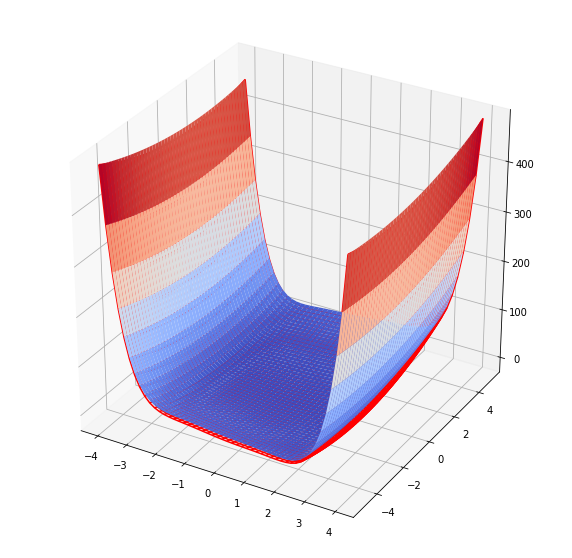

iter:  1
epsilionF:  20.5 UBD:  0.0 LBD:  -20.5
max delta:  10.0
iter:  2
epsilionF:  9.117199784273627 UBD:  0.0 LBD:  -9.117199784273627
max delta:  8.0
iter:  3
epsilionF:  9.117199784273627 UBD:  0.0 LBD:  -9.117199784273627
max delta:  8.0
iter:  4
epsilionF:  3.9354740339568637 UBD:  0.0 LBD:  -3.9354740339568637
max delta:  5.0
iter:  5
epsilionF:  3.9354740339568637 UBD:  0.0 LBD:  -3.9354740339568637
max delta:  5.0
iter:  6
epsilionF:  2.408887668140823 UBD:  0.0 LBD:  -2.408887668140823
max delta:  4.0
iter:  7
epsilionF:  2.408887668140823 UBD:  0.0 LBD:  -2.408887668140823
max delta:  4.0
iter:  8
epsilionF:  1.1921015845228693 UBD:  0.0 LBD:  -1.1921015845228693
max delta:  5.0
iter:  9
epsilionF:  1.1921015845228693 UBD:  0.0 LBD:  -1.1921015845228693
max delta:  5.0
iter:  10
epsilionF:  0.6725231504341853 UBD:  0.0 LBD:  -0.6725231504341853
max delta:  2.5
iter:  11
epsilionF:  0.6725231504341853 UBD:  0.0 LBD:  -0.6725231504341853
max delta:  2.5
iter:  12
epsilionF: 

In [14]:
# objective function: camel 3
lb = [-4.0, -5.0]
ub = [4.0, 5.0]
alpha = 0.5

plotFunctionAndRelaxation(camel3, lb, ub, alpha)
UBD = branchAndBoundAlgorithm(camel3, lb, ub, alpha)

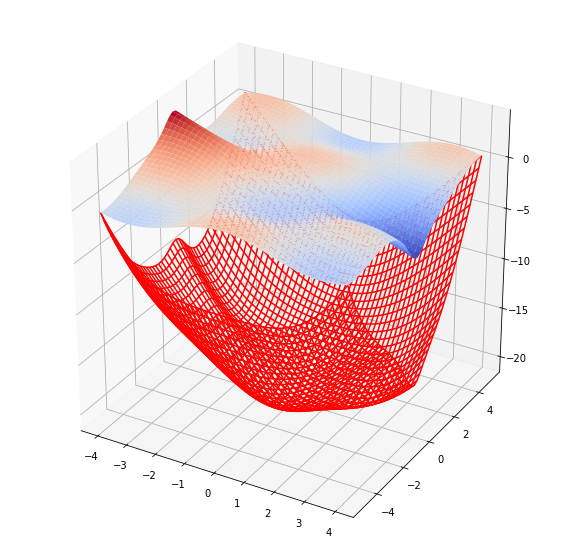

iter:  1
epsilionF:  17.053182871134847 UBD:  -4.026823501534824 LBD:  -21.080006372669672
max delta:  10.0
iter:  2
epsilionF:  7.894237003910162 UBD:  -4.026823501534824 LBD:  -11.921060505444986
max delta:  8.0
iter:  3
epsilionF:  6.952772932897724 UBD:  -4.026823501534824 LBD:  -10.979596434432548
max delta:  8.0
iter:  4
epsilionF:  2.1266229210790577 UBD:  -4.026823501534824 LBD:  -6.153446422613881
max delta:  5.0
iter:  5
epsilionF:  1.2506601009059297 UBD:  -4.026823501534824 LBD:  -5.277483602440753
max delta:  5.0
iter:  6
epsilionF:  1.1674867508732198 UBD:  -4.0268235015348255 LBD:  -5.194310252408045
max delta:  5.0
iter:  7
epsilionF:  0.8673945785002459 UBD:  -4.0268235015348255 LBD:  -4.894218080035071
max delta:  4.0
iter:  8
epsilionF:  0.8410372170736853 UBD:  -4.0268235015348255 LBD:  -4.867860718608511
max delta:  5.0
iter:  9
epsilionF:  0.47804281439197105 UBD:  -4.0268235015348255 LBD:  -4.5048663159267965
max delta:  4.0
iter:  10
epsilionF:  0.20742265874806

In [15]:
# objective function: adjiman
lb = [-4.0, -5.0]
ub = [4.0, 5.0]
alpha = 0.5

plotFunctionAndRelaxation(adjiman, lb, ub, alpha)
UBD = branchAndBoundAlgorithm(adjiman, lb, ub, alpha)

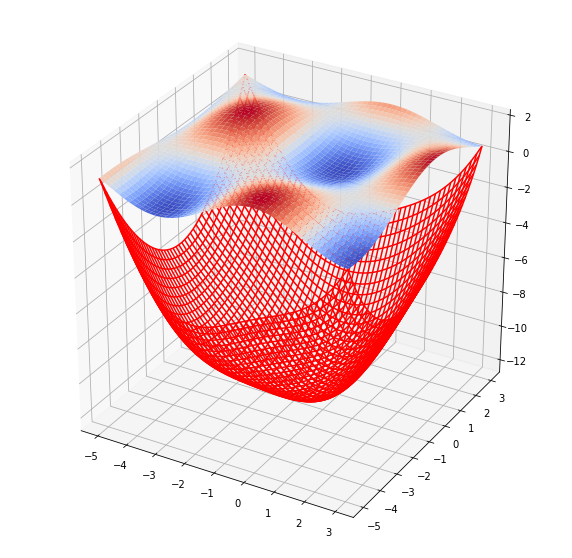

iter:  1
epsilionF:  12.437622843264252 UBD:  1.8635759602148028e-11 LBD:  -12.437622843245617
max delta:  8.0
iter:  2
epsilionF:  7.637622843264882 UBD:  1.8635759602148028e-11 LBD:  -7.6376228432462465
max delta:  8.0
iter:  3
epsilionF:  6.452328988890086 UBD:  1.8635759602148028e-11 LBD:  -6.45232898887145
max delta:  8.0
iter:  4
epsilionF:  2.8769588814107996 UBD:  1.8635759602148028e-11 LBD:  -2.876958881392164
max delta:  4.0
iter:  5
epsilionF:  2.837622843264975 UBD:  1.8635759602148028e-11 LBD:  -2.837622843246339
max delta:  4.0
iter:  6
epsilionF:  2.072029419102857 UBD:  1.6819878823071122e-13 LBD:  -2.0720294191026887
max delta:  4.0
iter:  7
epsilionF:  1.8475782332972666 UBD:  0.0 LBD:  -1.8475782332972666
max delta:  4.0
iter:  8
epsilionF:  1.6523289888717332 UBD:  0.0 LBD:  -1.6523289888717332
max delta:  4.0
iter:  9
epsilionF:  1.534724648714119 UBD:  0.0 LBD:  -1.534724648714119
max delta:  4.0
iter:  10
epsilionF:  1.4273306842795739 UBD:  0.0 LBD:  -1.42733068

In [16]:
# objective function: griewank
lb = [-5.0, -5.0]
ub = [3.0, 3.0]
alpha = 0.4
plotFunctionAndRelaxation(griewank, lb, ub, alpha)
UBD = branchAndBoundAlgorithm(griewank, lb, ub, alpha)